In [1]:
"""Note: this nb is self-contained, just requires the one saved pkl model in the results folder.
The point is to see how the Emb-grams model does on unseen tokens at test-time.
Specifically, we check the top-interacting words that exist in the test set but not in the train set.
"""

%load_ext autoreload
%autoreload 2
import torch
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datasets
import numpy as np
import os.path
from spacy.lang.en import English
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
from auggam import analyze_helper
import dvu
dvu.set_style()
import pandas as pd
from os.path import join as oj
import string
from typing import List
import data
import matplotlib.pyplot as plt
import seaborn as sns
from auggam import config
pd.set_option('display.max_rows', None)

# Load embeddings (model trained on whole dataset)

In [2]:
# load embs for indivual words/bigrams
embs = pkl.load(open(oj(config.misc_dir, "word_embs_sst_train.pkl"), "rb"))
embs2 = pkl.load(open(oj(config.misc_dir, "embs2_sst_top_interactions.pkl"), "rb"))

# also load coef data
df = pd.read_csv(oj(config.misc_dir, "df_unigram_sst.csv"), index_col=0)
df2 = pd.read_csv(oj(config.misc_dir, "df_bigram_sst.csv"), index_col=0)
d = pkl.load(open(oj(config.misc_dir, "top_interacting_words_df2.pkl"), "rb"))

In [3]:
d = analyze_helper.add_bert_coefs(
    d, df, embs, embs2,
    cached_model=oj(config.repo_dir, 'results/sst_bert_finetuned_ngrams=2.pkl')
)

# get sst data
dataset = analyze_helper.get_sst_dataset()

/home/chansingh/.llm/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/chansingh/.llm/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Found cached dataset sst2 (/home/chansingh/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
trigrams = np.array(pkl.load(open(oj(config.misc_dir, 'trigrams.pkl'), 'rb')))
embs3 = pkl.load(open(oj(config.misc_dir, "embs3_sst_top_interactions.pkl"), "rb"))
bert_coefs3 = analyze_helper.get_bert_coefs(embs3)
assert trigrams.size == bert_coefs3.size

/home/chansingh/.llm/lib/python3.9/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


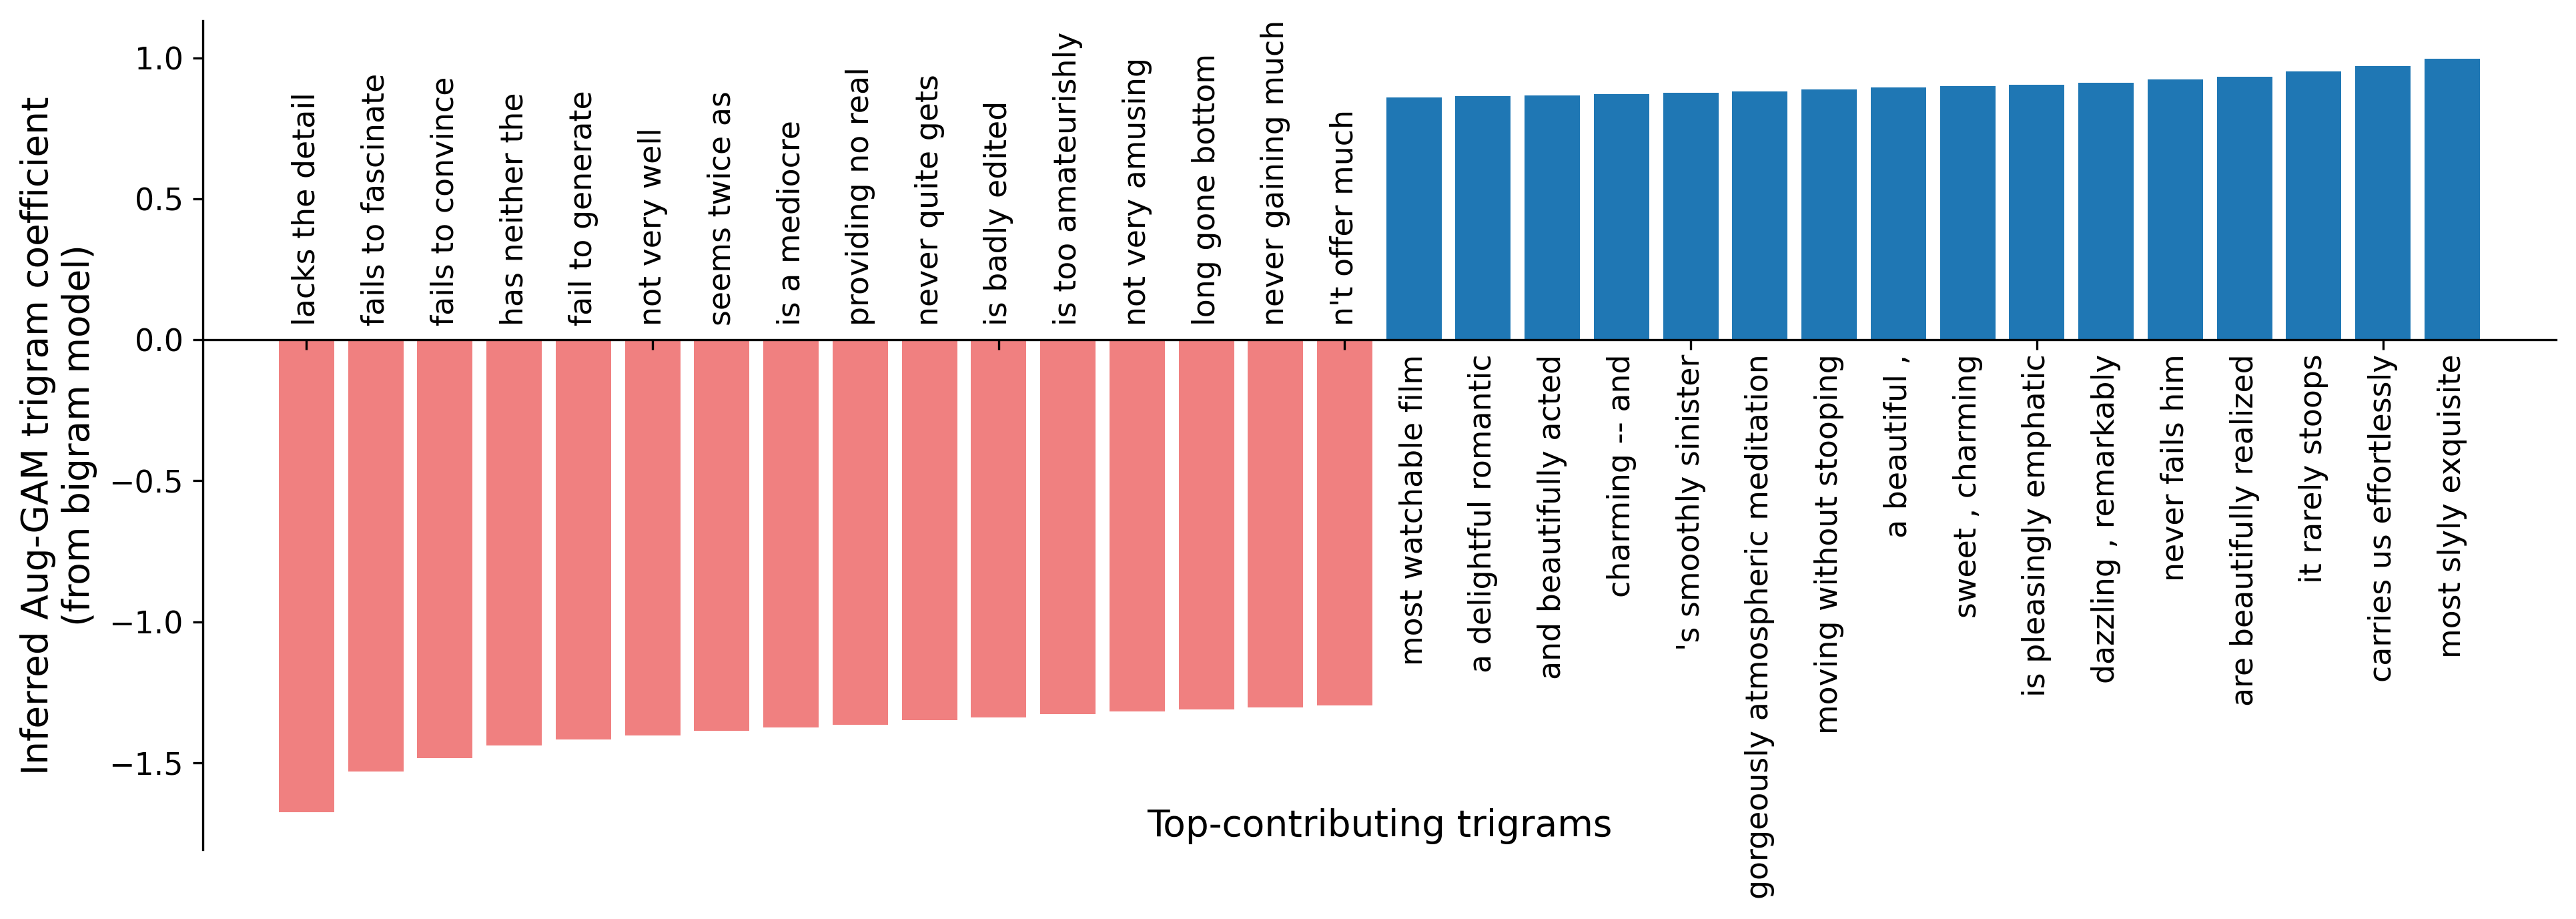

In [6]:
plt.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(dpi=300, figsize=(13, 5))


# pick top
num_top = 16
# logits = embs @ logistic.coef_.squeeze() # + logistic.intercept_
logits = bert_coefs3
seqs = trigrams
args = np.argsort(logits)
args = np.concatenate((args[::20][:num_top], args[::20][-num_top:]))

# make plot
x = np.arange(args.size)
y = logits[args]
labels = np.array(seqs)[args].astype(str).tolist()
p1 = ax.bar(x=x, height=y,
       color=['lightcoral'] * num_top + ['C0'] * num_top)
ax.set_xticklabels([])
# ax.set_ticks()
# remove the extra tick on the negative bar
# ax.set_xticks([idx for (idx, x) in enumerate(performance) if x > 0])
ax.spines["bottom"].set_position(("data", 0))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


label_offset = 0.05
for label, (x_position, y_position) in zip(labels, enumerate(y)):
    if y_position > 0:
        label_y = -label_offset
        ax.text(x_position, label_y, label, ha="center", va="top", rotation=90)
    else:
        label_y = +label_offset
        ax.text(x_position, label_y, label, ha="center", va="bottom", rotation=90)
# Placing the x-axis label, note the transformation into `Axes` co-ordinates
# previously data co-ordinates for the x ticklabels
ax.text(0.5, 0.05, "Top-contributing trigrams", ha="center", va="top", transform=ax.transAxes, fontsize='large')
plt.ylabel('Inferred Aug-GAM trigram coefficient\n(from bigram model)', fontsize='large')
plt.xlim([-1.5 , x.size + 0.5])
plt.tight_layout()
plt.savefig(oj(config.repo_dir, 'results/trigram-unseen-contributions.pdf'))
plt.show()

# Look at the unseen bigrams that yield the largest BOW coefs.

These bigrams tend to be quite rare / unappealing, so we probably want to use a model that was trained on less data.

In [20]:
# get vocabs
tok_simp = English().tokenizer
tokenizer_func = lambda x: [str(x) for x in tok_simp(x)]
v_train = CountVectorizer(tokenizer=tokenizer_func, ngram_range=(2, 2)).fit(
    dataset["train"]["sentence"]
)
v_test = CountVectorizer(tokenizer=tokenizer_func, ngram_range=(2, 2)).fit(
    dataset["validation"]["sentence"]
)
bigrams_train = sorted(list(v_train.vocabulary_.keys()))
bigrams_test = sorted(list(v_test.vocabulary_.keys()))


# calculate coefs
matrix_test = v_test.transform(dataset['validation']['sentence'])
tot_counts2 = pd.DataFrame(matrix_test.sum(axis=0), columns=v_test.get_feature_names())
m_test = LogisticRegressionCV()
m_test.fit(matrix_test, dataset['validation']['label'])
coef_test = m_test.coef_.flatten() # note -- coef has not been mapped to same idxs as words

# sort to put largest coefs at top
idxs_sorted = np.argsort(np.abs(coef_test))[::-1]
bigrams_test_sorted = np.array(bigrams_test)[idxs_sorted]
coef_test_sorted = coef_test[idxs_sorted]

# filter by unseen
idxs_unseen = list(map(lambda x: x not in bigrams_train, bigrams_test_sorted))
bigrams_unseen_sorted = bigrams_test_sorted[idxs_unseen]
coef_unseen_sorted = coef_test_sorted[idxs_unseen]

/home/chansingh/embedded-ngrams/.embgrams/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [47]:
for i in range(10):
    print(bigrams_unseen_sorted[i], coef_test[i])

flair . 0.03577738959642746
charm to -0.0505954592645493
deep and -0.08153103409847423
too , 0.09298732605922387
who love -0.03619972128826575
a giggle 0.028262171263907686
a minute 0.05489001068525908
- this -0.06006566340714442
mesmerizing . 0.08137781419676555
cool ? 0.05489001068525908
